 #                                                **Exploring Breathcode data**

### Importing necessary libraries

In [1]:
pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### Loading the data

In [3]:
data = pd.read_csv('../sources/All_Form_Entries.csv', dtype={'utm_content': 'object', 'current_download': 'object', 'state': 'object', 'lead_type': 'object', 'lead_generation_app':'object'})

/tmp/ipykernel_3000/3606296293.py:1: DtypeWarning: Columns (28,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../sources/All_Form_Entries.csv', dtype={'utm_content': 'object', 'current_download': 'object', 'state': 'object', 'lead_type': 'object', 'lead_generation_app':'object'})


## Data Cleaning

**Changing column type of date columns**

In [4]:
data['created_at'].head()

0    2020-11-28 07:46:58.469198+00:00
1    2021-06-22 04:29:19.572742+00:00
2    2022-04-19 02:00:13.390512+00:00
3    2020-09-23 21:22:11.861392+00:00
4    2020-09-24 04:36:26.286289+00:00
Name: created_at, dtype: object

In [5]:
#Changing type of 3 datetime columns 

data[['created_at','updated_at','won_at']] = data[['created_at','updated_at','won_at']].apply(pd.to_datetime).copy()

In [6]:
data['created_at'] = data['created_at'].dt.strftime("%Y-%m-%d %H:%M:%S")
data['updated_at'] = data['updated_at'].dt.strftime("%Y-%m-%d %H:%M:%S")
data['won_at'] = data['won_at'].dt.strftime("%Y-%m-%d %H:%M:%S")

In [7]:
data[['created_at','updated_at','won_at']] = data[['created_at','updated_at','won_at']].apply(pd.to_datetime).copy()

In [8]:
#The column of our interest is 'Created_at' so we'll convert and separate that one first

data['year-month'] = data['created_at'].dt.strftime('%Y-%m')
data['created_time'] = data['created_at'].dt.strftime('%H:%M:%S')

**Create a full name column**

In [9]:
#Combine first and last name ignoring nulls
data['fullname'] = data['first_name'].fillna('') + str(' ') + data['last_name'].fillna('')

In [10]:
# shift column 'Fullname' to first position
fourth_column = data.pop('fullname')

# insert column using insert(position,column_name,fourth_column) function
data.insert(3, 'fullname', fourth_column)

**Dropping columns with 100% of null values and also non relevant columns**

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/seaborn/distributions.py:264: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 1500x1500 with 0 Axes>

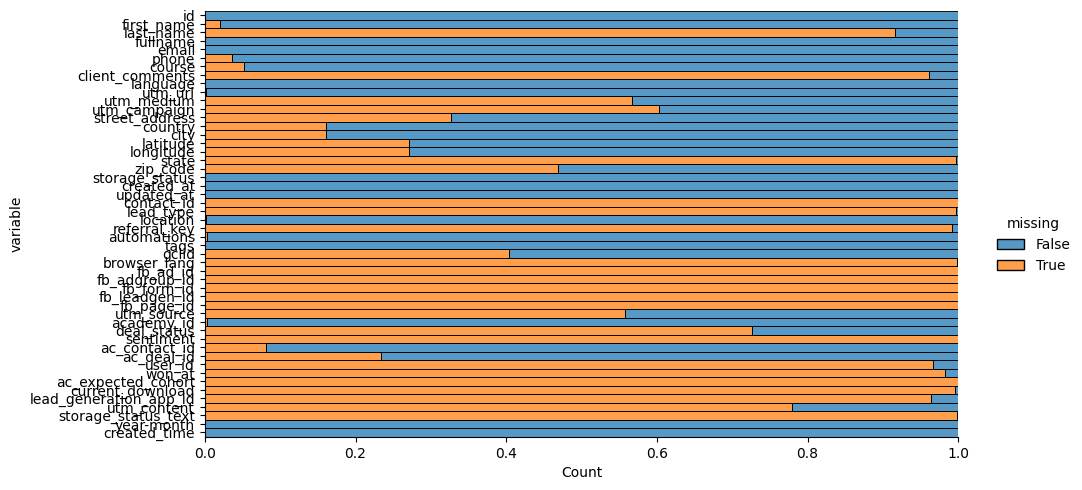

In [11]:
plt.figure(figsize=(15,15))
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=2
)
plt.show()

In [12]:
#Let's drop columns that have all null values.

data.dropna(axis=1, how='all', inplace=True)

In [13]:
#Let's also drop not relevant columns.

data = data.drop(['phone','client_comments','street_address','city','latitude','longitude','state',
                  'zip_code','referral_key','browser_lang','ac_expected_cohort','current_download','utm_content',
                  'storage_status','user_id','ac_contact_id','first_name','last_name','storage_status_text'], axis=1).copy()

In [14]:
#Dropping rows that were only for test (identify the rest of test emails pending)
data.drop(data[data['utm_source'] == 'test_s'].index, inplace = True)
data.drop(data[data['utm_source'] == 'fintech'].index, inplace = True)

In [15]:
#some test rows identified
data = data[data["email"].str.contains("@4geeks") == False]

**Reduce dataframe to only one application (first) per email, and combine with duplicated (if so)**

In [16]:
#How many unique emails are there in the dataset?
data['email'].nunique()

38969

**Testing the removal and combination of duplicates**

In [17]:
# Creating a duplicates dataframe to try different methods to combine data

duplicateRowsDF = data[data.duplicated(['email'],keep= False)]
print("All Duplicate Rows based on email:"," ", duplicateRowsDF.shape)

duplicateRowsDF.groupby(['email','created_at','utm_medium','utm_source']).size()

All Duplicate Rows based on email:   (20953, 24)


email                         created_at           utm_medium  utm_source 
02sergioconde@gmail.com       2021-11-02 01:19:40  cpc         google         1
1211eka@gmail.com             2022-10-10 07:58:13  ppc         Facebook       1
123malber.olivares@gmail.com  2022-05-08 02:08:10  ppc         fb             1
                              2022-06-24 02:39:59  ppc         fb             1
1928nathalia@gmail.com        2022-02-14 22:58:04  cpc         google         1
                                                                             ..
zuberlye@gmail.com            2022-03-02 20:25:26  ppc         ig             1
zuluaganeider@gmail.com       2022-04-27 19:16:07  cpc         google         1
                              2022-04-27 19:32:06  cpc         google         1
zumanzuesaubrey29@gmail.com   2022-05-17 14:52:29  referral    careerkarma    1
                              2022-05-17 14:54:14  cpc         google         1
Length: 6556, dtype: int64

In [18]:
duplicateRowsDF = duplicateRowsDF.replace("Nan", np.nan)

# Option 1

data1 = duplicateRowsDF.sort_values("created_at")


In [19]:
data1.head(7)

,id,fullname,email,course,language,utm_url,utm_medium,utm_campaign,country,created_at,...,tags,gclid,utm_source,academy_id,deal_status,ac_deal_id,won_at,lead_generation_app_id,year-month,created_time
33,99,Patricia Sanchez,2231valemati@gmail.com,full-stack,es,https://4geeksacademy.co/es/course/desarrollo-...,NaN,NaN,Venezuela,2020-09-22 11:28:12,...,request_more_info,NaN,NaN,1.0,NaN,NaN,NaT,NaN,2020-09,11:28:12
47,100,Patricia Sanchez,2231valemati@gmail.com,NaN,es,https://4geeksacademy.co/es/aplica,NaN,NaN,Venezuela,2020-09-22 11:54:39,...,website-lead,NaN,NaN,8.0,NaN,NaN,NaT,NaN,2020-09,11:54:39
13,106,Annelis Fuenmayor,annelisfuenmayor@gmail.com,full-stack,es,https://4geeksacademy.co/us/apply,NaN,NaN,Chile,2020-09-22 13:07:16,...,website-lead,NaN,NaN,5.0,NaN,NaN,NaT,NaN,2020-09,13:07:16
50,107,Anne F,annelisfuenmayor@gmail.com,software-engineering,es,https://4geeksacademy.co/us/apply,NaN,NaN,Chile,2020-09-22 13:07:38,...,website-lead,NaN,NaN,5.0,NaN,NaN,NaT,NaN,2020-09,13:07:38
52,112,Patricia Sanchez,2231valemati@gmail.com,full-stack,es,https://4geeksacademy.co/es/aplica,NaN,NaN,Venezuela,2020-09-22 15:30:37,...,website-lead,NaN,NaN,8.0,NaN,NaN,NaT,NaN,2020-09,15:30:37
28857,113,Daniel Suarez,ingsuarezcda@gmail.com,NaN,es,https://4geeksacademy.co/us/location/impact-hub,NaN,NaN,Spain,2020-09-22 15:48:03,...,request_more_info,NaN,NaN,6.0,NaN,15186.0,NaT,NaN,2020-09,15:48:03
7,114,Patricia Sanchez,2231valemati@gmail.com,full-stack,es,https://4geeksacademy.co/es/aplica,NaN,NaN,NaN,2020-09-22 17:16:51,...,website-lead,NaN,NaN,7.0,NaN,NaN,NaT,NaN,2020-09,17:16:51


In [20]:
data1 = data1.groupby("email").first().reset_index()
data1.head()

,email,id,fullname,course,language,utm_url,utm_medium,utm_campaign,country,created_at,...,tags,gclid,utm_source,academy_id,deal_status,ac_deal_id,won_at,lead_generation_app_id,year-month,created_time
0,010.sergio@gmail.com,982,Sergio,software-engineering,es,https://4geeksacademy.co/es/course/ingenieria-...,None,None,Remoto,2020-11-05 22:43:38,...,request_more_info,Cj0KCQiA7qP9BRCLARIsABDaZzjSqM5HLJ_mnXJR0chAmh...,None,7.0,None,NaN,NaT,NaN,2020-11,22:43:38
1,02sergioconde@gmail.com,15671,Sergio,full-stack,en,https://4geeksacademy.com/es/aplica,cpc,12321016929,Spain,2021-11-02 01:19:40,...,website-lead,CjwKCAjwoP6LBhBlEiwAvCcthEg_m41UBa1VgX4neAax9f...,google,6.0,LOST,29045.0,NaT,NaN,2021-11,01:19:40
2,07.ebad@gmail.com,40414,Ebad Abid,full-stack,en,https://4geeksacademy.com/us/apply,None,None,France,2022-06-29 16:41:53,...,website-lead,None,None,4.0,None,57652.0,NaT,NaN,2022-06,16:41:53
3,0wenbartlet@gmail.com,17693,Owen bartlett,full-stack,en,https://4geeksacademy.com/us/coding-bootcamps/...,None,None,Mexico,2021-11-30 21:16:31,...,request_more_info,None,None,7.0,None,30652.0,NaT,NaN,2021-11,21:16:31
4,10903alm@gmail.com,11875,Alpheus Legoke Mokgalaka,machine-learning-engineering,us,https://4geeksacademy.com/us/landing/scholarsh...,None,None,France,2021-09-14 19:07:17,...,website-lead,None,landingjobs?utm_medium=machine-learning-engine...,10.0,LOST,25851.0,NaT,NaN,2021-09,19:07:17


In [21]:
data1[data1['email']== 'afuenmayor@4geeks.co']

,email,id,fullname,course,language,utm_url,utm_medium,utm_campaign,country,created_at,...,tags,gclid,utm_source,academy_id,deal_status,ac_deal_id,won_at,lead_generation_app_id,year-month,created_time


**Implementing the removal and combination of duplicates**

In [22]:
data = data.replace("Nan", np.nan).copy()
data = data.sort_values("created_at").copy()
data = data.groupby("email").first().reset_index()

In [23]:
data.shape

(38969, 24)

--------> **a way to discover where do utm_source strange labels belong to:** 

In [24]:
data[data['utm_source'] =='clubhouse']['utm_medium']

1758    None
Name: utm_medium, dtype: object

**--------> a way to discover where do utm_medium strange labels belong to:**

In [25]:
data[data['utm_source'] =='clubhouse']

,email,id,fullname,course,language,utm_url,utm_medium,utm_campaign,country,created_at,...,tags,gclid,utm_source,academy_id,deal_status,ac_deal_id,won_at,lead_generation_app_id,year-month,created_time
1758,Zakaria.amine95@gmail.com,39526,Zakaria,full-stack,en,https://4geeksacademy.com/us/apply,None,None,France,2022-06-25 17:38:47,...,website-lead,None,clubhouse,10.0,None,56836.0,NaT,NaN,2022-06,17:38:47


**Let's identify if a lead has gclid assigning 1 for True, and 0 for False.**

In [26]:
data['has_gclid'] = np.where(data['gclid'].isnull(), '0', '1')

In [27]:
data['has_gclid'].value_counts()

1    25498
0    13471
Name: has_gclid, dtype: int64

**Fixing Courses**

In [28]:
data['course'].value_counts()

full-stack                      32479
software-engineering             1926
machine-learning-engineering     1748
full-stack-ft                    1308
machine-learning                   80
node-js                            48
full_stack                          9
machine-learning-enginnering        2
coding-introduction                 1
Name: course, dtype: int64

In [29]:
data['course'] = data['course'].replace(['full-stack-ft', 'full_stack', 'full-stack,software-engineering',
                                         'coding-introduction','outcomes'], 'full-stack')

In [30]:
data['course'] = data['course'].replace(['machine-learning', 'machine-learning-enginnering'], 
                                        'machine-learning-engineering')

In [31]:
data['course'].value_counts()

full-stack                      33797
software-engineering             1926
machine-learning-engineering     1830
node-js                            48
Name: course, dtype: int64

**4. Location**

Let's correct the 2 different typings in Maracaibo and Cortijos

In [32]:
data['location'] = data['location'].replace(['maracaibo'], 'maracaibo-venezuela')

In [33]:
data['location'] = data['location'].replace(['los-cortijos-caracas'], 'caracas-venezuela')

In [34]:
data['location'] = data['location'].replace(['lisboa-portugal'], 'lisbon-portugal')

In [35]:
data['location'].value_counts()

caracas-venezuela        6894
santiago-chile           6212
madrid-spain             5882
downtown-miami           3848
bogota-colombia          3360
online                   3171
costa-rica               3002
europe                   2233
buenosaires-argentina     993
orlando                   982
mexicocity-mexico         848
quito-ecuador             271
panamacity-panama         252
montevideo-uruguay        198
munich-germany            187
sanjose-uruguay           147
toronto-canada             74
barcelona-spain            71
lisbon-portugal            42
valencia-spain             42
malaga-spain               42
berlin-germany             35
lima-peru                  30
lapaz-bolivia              26
rome-italy                 25
hamburg-germany            17
maracaibo-venezuela        12
dublin-ireland              9
milan-italy                 4
Name: location, dtype: int64

**Fixing Language**

Consider 'us' language inside 'en' for english.

In [36]:
data['language'].value_counts()

en    18867
es    14729
us     5373
Name: language, dtype: int64

In [37]:
data['language'] = data['language'].replace('us', 'en')

In [38]:
data['language'].value_counts()

en    24240
es    14729
Name: language, dtype: int64

**Fixing Academy_id**

In [39]:
data['academy_id'] = np.where((data['location'] == 'maracaibo-venezuela'),
                                2.0, data['academy_id'])
data['academy_id'] = np.where((data['location'] == 'toronto-canada'),
                                4.0, data['academy_id'])
data['academy_id'] = np.where((data['location'] == 'costa-rica') |
                                (data['location'] == 'sanjose-uruguay'),
                                7.0, data['academy_id'])

**Fixing utm_source**

In [40]:
data['utm_source'].value_counts()

google                                                 8182
instagram                                              2498
facebook                                               2285
ig                                                     1936
fb                                                     1638
careerkarma                                            1425
landingjobs?utm_medium=machine-learning-engineering     538
coursereport                                            218
Facebook                                                173
Facebook ads                                            131
aprendemas                                              123
landingjobs?utm_medium=full-stack                       115
zoho_recruite                                            81
facebook_instagram                                       55
bing                                                     48
ActiveCampaign                                           45
landingjobs?utm_medium=RRSS             

In [41]:
#Before making any changes, we should make sure where do those long numbers belong to: instagram or facebook?

pd.options.display.max_rows = 200
data.groupby(['utm_source','utm_medium']).size()

utm_source                                           utm_medium                                    
23848557212380143                                    Instagram_Stories                                    1
23848655532190143                                    Facebook_Mobile_Feed                                 1
23849317251630143                                    Instagram_Feed                                       1
23850705303260143                                    Facebook_Mobile_Feed                                 1
23850859670310143                                    Facebook_Mobile_Feed                                 1
4geeks                                               rrss                                                22
ActiveCampaign                                       email                                               45
Business Manager IG                                  lead gen                                             2
CourseReport                        

**First Conditional assignations**

In [42]:
data['utm_medium'] = np.where((data['utm_source'] == 'Facebook ads') |
                                (data['utm_source'] == 'Facebook_Marketplace') |
                                (data['utm_source'] == 'Facebook_Mobile_Feed') |
                                (data['utm_source'] == 'facebook_awareness') |
                                (data['utm_source'] == 'Facebook_Stories') |
                                (data['utm_source'] == 'Facebook_Desktop_Feed') |
                                (data['utm_source'] == 'Business Manager IG') |
                                (data['utm_source'] == 'Instagram_Feed') |
                                (data['utm_source'] == 'Instagram_Stories'),
                                'cpc', data['utm_medium'])

data['utm_source'] = np.where((data['utm_medium'] == 'Instagram_Stories') |
                                (data['utm_medium'] == 'Instagram_Feed'),
                                'instagram', data['utm_source'])

data['utm_source'] = np.where((data['utm_medium'] == 'Facebook_Mobile_Feed'),
                                'facebook', data['utm_source'])

**Fixing utm_source spelling**

In [43]:
#Fixing spelling of sources in utm_source

data['utm_source'] = data['utm_source'].replace('LInkedin', 'linkedin')
data['utm_source'] = data['utm_source'].replace('CourseReport', 'coursereport')
data['utm_source'] = data['utm_source'].replace(['landingjobs?utm_medium=machine-learning-engineering',
                                            'landingjobs?utm_medium=full-stack', 'landingjobs?utm_medium=RRSS'],
                                            'landingjobs')
data['utm_source'] = data['utm_source'].replace('google_ads', 'google')
data['utm_source'] = data['utm_source'].replace(['Business Manager IG', 'Instagram_Feed', 'ig', 'Instagram_Stories'], 'instagram')
data['utm_source'] = data['utm_source'].replace(['Facebook', 'Facebook ads', 'Facebook_Marketplace', 'Facebook_Mobile_Feed',
                                            'facebook_instagram', 'fb', 'an', 'facebook_awareness', 'Facebook_Stories',
                                            'Facebook_Desktop_Feed'], 'facebook')
data['utm_source'] = data['utm_source'].replace('4geeks', 'ticjob')

**8. Fixing utm_medium:** 

Assing 'referral' to all schoolpage values.
    
Assign referral to all landingjob utm_source.
    
Verify with gclid if a medium should be cpc or not.
    
Join cpc with ppc.


In [44]:
#Making assignations to referral and cpc

data['utm_medium'] = data['utm_medium'].replace(['schoolpage', 'coursereportschoolpage', 'schoolpage?utm_source=careerkarma',
                                    'Blog', 'affiliate_email', 'rrss', 'inscripcion', 'event'], 'referral')
data['utm_medium'] = data['utm_medium'].replace(['ppc', 'FB paid', 'Facebook_Mobile_Feed', 'Instagram_Stories', 'Instagram_Feed'],
                                    'cpc')
data['utm_medium'] = np.where((data['utm_source'] == 'linkedin') & (data['utm_medium'] == 'social'),
                          'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'linkedin') & (data['utm_medium'] == 'Inmail'),
                          'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'landingjobs'),
                                'referral', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'careerkarma') & (data['utm_medium'].isnull() == True), 
                          'referral', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'facebook') & (data['utm_medium'].isnull() == True),
                          'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_source'] == 'zoho_recruite') & (data['utm_medium'] == 'cpc'),
                          'referral', data['utm_medium'])

**Assignation of null source and medium according to Gclid**

In [45]:
#Convert medium in cpc or referral if gclid is not null

data['utm_medium'] = np.where((data['utm_medium'].isnull()) &
                    (data['gclid'].str.startswith('Cj')), 
                    'cpc', data['utm_medium'])

data['utm_medium'] = np.where((data['utm_medium'].isnull()) &
                    (data['gclid'].str.startswith('cl')), 
                    'referral', data['utm_medium'])

#google

data['utm_source'] = np.where((data['utm_source'].isnull()) &
                    ((data['gclid'].str.startswith('Cj')) | 
                    (data['gclid'].str.startswith('EA'))),
                    'google', data['utm_source'])


#facebook

data['utm_source'] = np.where((data['utm_source'].isnull()) &
                    (data['gclid'].str.startswith('PAA')),
                    'facebook', data['utm_source'])


#careerkarma

data['utm_source'] = np.where((data['utm_source'].isnull()) &
                    (data['gclid'].str.startswith('cl')),
                    'careerkarma', data['utm_source'])

**Assign lead_types depending on the tags.**

In [46]:
data['tags'].value_counts()

request_more_info                    23253
website-lead                         14372
newsletter                             623
contact-us                             244
utec-uruguay                           147
request_downloadable                   126
hiring-partner                          86
jobboard-lead                           80
website-lead,blacks-in-technology       20
download_outcome                        16
Name: tags, dtype: int64

In [47]:
data.loc[data['tags'] == 'request_more_info', 'lead_type'] = 'SOFT'
data.loc[data['tags'] == 'website-lead', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'newsletter', 'lead_type'] = 'DISCOVERY'
data.loc[data['tags'] == 'contact-us', 'lead_type'] = 'SOFT'
data.loc[data['tags'] == 'utec-uruguay', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'jobboard-lead', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'hiring-partner', 'lead_type'] = 'OTHER'
data.loc[data['tags'] == 'download_outcome', 'lead_type'] = 'DISCOVERY'
data.loc[data['tags'] == 'website-lead,blacks-in-technology', 'lead_type'] = 'STRONG'
data.loc[data['tags'] == 'request_downloadable', 'lead_type'] = 'DISCOVERY'

In [48]:
data['lead_type'].value_counts()

SOFT         23497
STRONG       14619
DISCOVERY      765
OTHER           86
Name: lead_type, dtype: int64

**Creating new column to determine location integrity**

In [49]:
data['location'].value_counts()

caracas-venezuela        6894
santiago-chile           6212
madrid-spain             5882
downtown-miami           3848
bogota-colombia          3360
online                   3171
costa-rica               3002
europe                   2233
buenosaires-argentina     993
orlando                   982
mexicocity-mexico         848
quito-ecuador             271
panamacity-panama         252
montevideo-uruguay        198
munich-germany            187
sanjose-uruguay           147
toronto-canada             74
barcelona-spain            71
lisbon-portugal            42
valencia-spain             42
malaga-spain               42
berlin-germany             35
lima-peru                  30
lapaz-bolivia              26
rome-italy                 25
hamburg-germany            17
maracaibo-venezuela        12
dublin-ireland              9
milan-italy                 4
Name: location, dtype: int64

In [50]:
LATAM_COUNTRIES = ['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Paraguay','Peru','Uruguay','Venezuela','Belize',
                    'Costa Rica','Cuba','Dominican Republic','El Salvador','Guatemala','Haiti','Honduras','Jamaica','Mexico','Nicaragua',
                    'Panama','Saint Lucia','Antigua and Barbuda','Guyana','Suriname','Saint Kitts & Nevis','Bahamas','Barbados',
                    'Trinidad and Tobago','Grenada','St. Vincent & Grenadines','Dominica']

LATAM_LOCATIONS = ['caracas-venezuela','santiago-chile','bogota-colombia','online','costa-rica','buenosaires-argentina','mexicocity-mexico',
                    'quito-ecuador','panamacity-panama','montevideo-uruguay','sanjose-uruguay','lapaz-bolivia','lima-peru',
                    'maracaibo-venezuela']

EUROPE_COUNTRIES = ['Hungary','Belarus','Austria','Serbia','Switzerland','Germany','Holy See','Andorra','Bulgaria','United Kingdom',
                    'France','Montenegro','Luxembourg','Italy','Denmark','Finland','Slovakia','Norway','Ireland','Spain','Malta',
                    'Ukraine','Croatia','Moldova','Monaco','Liechtenstein','Poland','Iceland','San Marino','Bosnia and Herzegovina',
                    'Albania','Lithuania','North Macedonia','Slovenia','Romania','Latvia','Netherlands','Russia','Estonia','Belgium',
                    'Czech Republic','Greece','Portugal','Sweeden']

EUROPE_LOCATIONS = ['madrid-spain','europe','barcelona-spain','malaga-spain','munich-germany','berlin-germany','valencia-spain',
                    'rome-italy','lisbon-portugal','maracaibo-venezuela','hamburg-germany','dublin-ireland','milan-italy','europe']

In [51]:
data['country'] = data['country'].str.lower()
LATAM_COUNTRIES = list(map(str.lower,LATAM_COUNTRIES))
EUROPE_COUNTRIES = list(map(str.lower,EUROPE_COUNTRIES))

In [52]:
pip install python-slugify

Note: you may need to restart the kernel to use updated packages.


In [53]:
from slugify import slugify

data['country'] = data['country'].astype(str).apply(lambda x :slugify(x))

In [54]:
correct_location = []

for row in data.itertuples(index=False):
    if str(row.country) in str(row.location):    
        correct_location.append(row.location)
    elif str(row.country) == 'united-states':    
        correct_location.append('downtown-miami')
    elif str(row.country) in LATAM_COUNTRIES and (v for v in LATAM_LOCATIONS if str(row.country) in v):  
        latam_search = str(row.country)
        latam_match = list(filter(lambda x: latam_search in x, LATAM_LOCATIONS))
        correct_location.append(latam_match)
    elif str(row.country) in EUROPE_COUNTRIES and str(row.country) in EUROPE_LOCATIONS:
        europe_search = str(row.country)
        europe_match = list(filter(lambda x: europe_search in x, EUROPE_LOCATIONS))
        correct_location.append(europe_match)
    elif str(row.country) in LATAM_COUNTRIES: 
        correct_location.append('online')
    elif str(row.country) in EUROPE_COUNTRIES:  
        correct_location.append('europe')        
    else:           
        correct_location.append('No location assigned')

In [55]:
data['correct_location'] = correct_location

In [56]:
f = lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
data['correct_location'] = data['correct_location'].apply(f)

In [57]:
data[['country','location','correct_location']]

,country,location,correct_location
0,remote,europe,No location assigned
1,venezuela,caracas-venezuela,caracas-venezuela
2,united-states,downtown-miami,downtown-miami
3,venezuela,bogota-colombia,"caracas-venezuela,maracaibo-venezuela"
4,remoto,online,No location assigned
...,...,...,...
38964,none,downtown-miami,No location assigned
38965,ecuador,quito-ecuador,quito-ecuador
38966,venezuela,costa-rica,"caracas-venezuela,maracaibo-venezuela"
38967,france,europe,europe


In [58]:
data['utm_source'].value_counts()

google                         15213
instagram                       4456
facebook                        4451
careerkarma                     1425
landingjobs                      683
coursereport                     220
aprendemas                       123
zoho_recruite                     81
bing                              48
ActiveCampaign                    45
ticjob                            40
PR?utm_medium=nota-prensa-1       15
linkedin                          10
python-es                          7
qsd.com                            6
hired                              5
bootcamprankings                   4
hs_email                           3
educaedu                           2
educaweb                           2
clubhouse                          1
youtube                            1
techhub                            1
women-who-code                     1
g                                  1
Name: utm_source, dtype: int64

In [59]:
# change name of null medium

data['utm_medium'] = np.where((data['utm_source'].isnull() == True) & (data['utm_medium'].isnull() == True),
                                'undefined & organic', data['utm_medium'])

# change name of null source

data['utm_source'] = np.where((data['utm_medium'] == 'undefined & organic'),
                                'undefined', data['utm_source'])

**Create a column that registers the filled % of each row**

In [60]:
filled_data = []

for i in range(len(data.index)):
    filled_data.append(((1-((data.iloc[i].isnull().sum())/len(data.columns)))*100))

In [61]:
#assign list to a new column in dataframe

data['% of row filled'] = filled_data

# make new column have only one decimal

data['% of row filled'].round(1)


# Add % symbol to end of column string
# 
# data['filled_data'] = data['filled_data'].astype(str) + '%'

0        80.8
1        84.6
2        84.6
3        88.5
4        80.8
         ... 
38964    88.5
38965    80.8
38966    80.8
38967    80.8
38968    92.3
Name: % of row filled, Length: 38969, dtype: float64

**Export a csv file for Mafe that shows all utm_campaign names and numbers**

In [62]:
utm_campaign_list = data.groupby(['utm_campaign', 'utm_source']).size().sort_values(ascending= False)

In [63]:
df_utm_campaigns = pd.DataFrame(utm_campaign_list)

In [64]:
df_utm_campaigns.to_csv('../output/utm_campaigns_dataframe.csv')